In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Table of Content :

In this notebook we will be covering:

* [Check GPU Availablilty](#Check-GPU-Available)
* [Tensor and Numpy Array](#Torch-Tensor-and-Numpy-array)
* [Torch DataSet in Pytorch](#Torch-Dataset)
* [Create DataLoader in Pytorch](#Create-DataLoader)
* [Training Model in Pytorch](#Modeling-Training)
* Other Questions: 
	* [` Super().__init__()`](#Super-and-init-in-Python)
	* [squeeze and unsqueeze](#Torch.squeeze())
	* [`__init__` and `__call__`](#Difference-init-and-call)

# Check GPU Available

In [5]:
def check_gpu():
    if torch.cuda.is_available():
        dev = torch.device("cuda:0") 
        print("Running on the GPU")
        gpu_info = !nvidia-smi
        gpu_info = '\n'.join(gpu_info)
        
        if gpu_info.find('failed') >= 0:
            print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
            print('and then re-execute this cell.')
        else:
            print(gpu_info)
    else:
        dev = torch.device("cpu")
        print("Running on the CPU")

check_gpu()

Running on the CPU


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.FloatTensor([0., 1., 2.])
X_train.is_cuda # false no cuda
X_train.to(device) # pass the X_train tensor into GPU if available else cpu


False

tensor([0., 1., 2.])

# Torch Tensor and Numpy array

In [7]:
# array
X_array = np.array([[1,0],[0,1]])
# tensor
X_tensor = torch.tensor([[1,0],[0,1]])

X_array, X_tensor

# can easily convert back and forth
X_tensor.numpy(), torch.from_numpy(X_array)

(array([[1, 0],
        [0, 1]]),
 tensor([[1, 0],
         [0, 1]]))

(array([[1, 0],
        [0, 1]]),
 tensor([[1, 0],
         [0, 1]]))

# Torch Dataset


The Dataset is an abstract class which holds the recipe for producing your data

can do complex operations to retrieve/transform your data in parallel for GPU training
You must implement the following methods:

```raw
  1.  __init__:  is used to initialise newly created object, and receives arguments 
  2.  __len__: length of the dataset
  3.  __getitem__: recipe for retrieving the i-th datapoint
```

## Example1: Turning Random X, y to Torch dataset

In [26]:
from torch.utils.data import Dataset

In [27]:
def random_linear_data(beta1, beta0, n):
    x = 10 * np.random.rand(n)
    y = beta1 * x + beta0 + np.random.rand()
    return x, y

In [28]:
class LinearDataset(Dataset):
    def __init__(self, beta1, beta0, n):
        """
        beta1, beta0: linear model coeffcients
        n: number of observation
        """
        x, y = random_linear_data(beta1, beta0, n)
        self.x, self.y =torch.from_numpy(x), torch.from_numpy(y)
        self.n = n
    
    def __len__(self):
        return len(x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [29]:
LinearDS = LinearDataset(beta1=2, beta0=10, n=200)
LinearDS.x[:10], LinearDS.y[:10]

(tensor([4.0602, 1.0785, 4.2940, 0.9729, 0.0830, 7.4732, 2.8182, 3.5015, 6.0932,
         0.0618], dtype=torch.float64),
 tensor([18.5179, 12.5545, 18.9857, 12.3433, 10.5636, 25.3441, 16.0340, 17.4006,
         22.5839, 10.5212], dtype=torch.float64))

In [30]:
# normally we check the data using iterator
# create an iterator and check the first 10 data

iterator, i = iter(LinearDS), 0
while i < 10:
    print( next(iterator) )
    i += 1

(tensor(4.0602, dtype=torch.float64), tensor(18.5179, dtype=torch.float64))
(tensor(1.0785, dtype=torch.float64), tensor(12.5545, dtype=torch.float64))
(tensor(4.2940, dtype=torch.float64), tensor(18.9857, dtype=torch.float64))
(tensor(0.9729, dtype=torch.float64), tensor(12.3433, dtype=torch.float64))
(tensor(0.0830, dtype=torch.float64), tensor(10.5636, dtype=torch.float64))
(tensor(7.4732, dtype=torch.float64), tensor(25.3441, dtype=torch.float64))
(tensor(2.8182, dtype=torch.float64), tensor(16.0340, dtype=torch.float64))
(tensor(3.5015, dtype=torch.float64), tensor(17.4006, dtype=torch.float64))
(tensor(6.0932, dtype=torch.float64), tensor(22.5839, dtype=torch.float64))
(tensor(0.0618, dtype=torch.float64), tensor(10.5212, dtype=torch.float64))


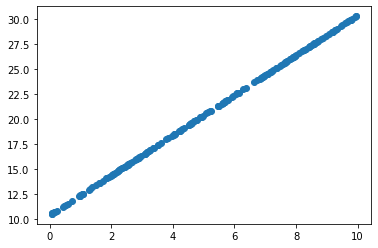

In [33]:
plt.scatter(LinearDS.x, LinearDS.y)

## Example2: Turning Iris Dataset into torch dataset

In [43]:
class Iris_DataSet(Dataset):
    def __init__(self):

        import seaborn as sns
        import pandas as pd
        iris = sns.load_dataset('iris')
        iris = iris[iris.species != 'virginica']

        self.df = iris
        self.n = iris.shape[0]
        self.species_val = {'setosa' : 0,
                            'versicolor': 1}
    
    def __len__(self):
        return self.n 
    
    def __getitem__(self, idx):
        # convert the row of data on-the-fly cuz sometimes when the dataset
        # is really large transform all the dataset into tensor in the __init__
        # could be time consuming, and RAM overwhelming as well 
        
        row = self.df.iloc[idx]
        # you need to transform to float
        x = torch.tensor([row['sepal_length'],
                          row['sepal_width']]).float()

        # you need to transform to float
        y = torch.tensor(self.species_val[row['species']]).float()
        
        return x, y

In [44]:
iris_ds = Iris_DataSet()
next(iter(iris_ds))

(tensor([5.1000, 3.5000]), tensor(0.))

In general a good rule of thumb for what to do on-the-fly vs. preprocessing:

- If it is random alteration (data augmentation): on-the-fly
- If it is a time-consuming step that is also the same each time: preprocessing

# Create DataLoader


The Dataloader helps us iterate over a Dataset

- can choose batch size (process the data in batch automatically) we could put less attension on batch
- can shuffle the data
- can be retrieved in parallel
- automatically collates tensors

In [51]:
from torch.utils.data import DataLoader

iris_dl = DataLoader(iris_ds, batch_size=10, shuffle=True)

x, y = next(iter(iris_dl))

# notice that since we set batch_size = 10
# each time the gradient descent will see this 10 rows of data shape=(10,2)
# and then update the gradient and corresponding parameters
print(x.shape, y.shape, "\n")

print(x, y)

torch.Size([10, 2]) torch.Size([10]) 

tensor([[5.6000, 3.0000],
        [6.3000, 3.3000],
        [5.0000, 3.6000],
        [6.2000, 2.2000],
        [5.8000, 4.0000],
        [5.5000, 2.4000],
        [5.7000, 3.0000],
        [6.3000, 2.3000],
        [6.0000, 2.7000],
        [6.7000, 3.1000]]) tensor([1., 1., 0., 1., 0., 1., 1., 1., 1., 1.])


# Modeling Training

In [110]:
import torch.nn as nn

class threeLayerNN(nn.Module): # 

    def __init__(self, input_dim, hidden_dim, output_dim):
        # super(threeLayerNN,self) will find threeeLayerNN's parent class (which is nn.Module) and inialize it (inherit)
        # 然后把类 Child 的对象转换为类 Parent 的对象, when threeLayerNN's forward function is called it will use children 
        # overwritten function, if other functions (not overwritten) 're got called, threeLayerNN will call parent's funciton
        super().__init__() # https://python3-cookbook.readthedocs.io/zh_CN/latest/c08/p07_calling_method_on_parent_class.html
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # will be automatically triggered when the x
        # pass through the threeLayerNN eg. y = model(x)
        # model = threeLayerNN()
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        # squeeze(x) 将输入张量x形状中的1 去除并返回。 如果输入是形如(A×1×B×1×C×1×D)，那么输出形状就为： (A×B×C×D)
        return torch.squeeze(x) # More anout torch squeeze https://zhuanlan.zhihu.com/p/86763381

In [111]:
model = threeLayerNN(2, 5, 1)
print(model, "\n")

from torchsummary import summary
summary(model, input_size = (2,), device='cpu')
#                            ^
#                            | 
#                  should mactch 2 in (2, 5, 1)

threeLayerNN(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 5]              15
              ReLU-2                    [-1, 5]               0
            Linear-3                    [-1, 1]               6
Total params: 21
Trainable params: 21
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


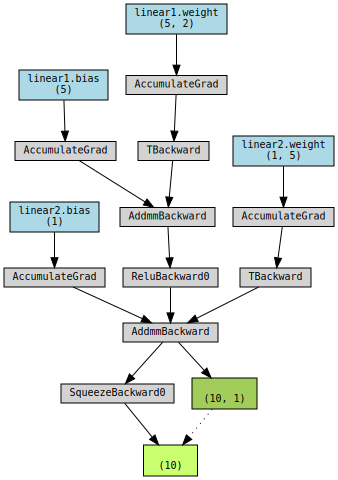

In [112]:
from torchviz import make_dot
make_dot(model(x), params=dict(list(model.named_parameters())))

In [125]:

dir(model) # we only rewrite forward and init other functions available 
# are inherited from parent class (nn,Module)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',


# Model Training

We need the following ingredients

- A loss function for our model
- An optimization algorithm

In [113]:
import torch.optim as optim

# feeds outputs through a sigmoid before computing BCE Loss
lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [117]:
def one_epoch_test(data):
# adjust the gradients according to one batch
    x, y = next(iter(data))
    # ----------------------------------------------------------------------------------------------------------
    # some layers will do different things during training/prediction (i.e. dropout)

    # model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which      behave different on the train and test procedures know what is going on and hence can behave accordingly.
    # More details: It sets the mode to train (see source code). You can call either model.eval() or model.train(mode=False) to  tell that you are testing. It is somewhat intuitive to expect train function to train model but it does not do that. It just sets the mode.
    # ----------------------------------------------------------------------------------------------------------
    model.train()
    # compute the predictions then loss
    y_pred = model(x)
    loss = lossFun(y_pred, y)
    print("loss: ", loss.item())
    # zero out the gradients in the optimizer (otherwise they will accumulate)
    optimizer.zero_grad()
    # compute the gradients w.r.t. loss function
    loss.backward()
    # adjust weights!
    optimizer.step()

In [118]:
one_epoch_test(data=iris_dl) # pass with data_loader

loss:  0.6760271787643433


In [119]:
# very crude training loop (you'll make a fancier one in your first lab)
def training(data, epoch):
    for epoch in range(epoch):
        for x, y in data:
            model.train()
            y_pred = model(x)
            loss = lossFun(y_pred, y)
            print("loss: ", loss.item())
            
            optimizer.zero_grad()
            # stochastic gradident descent
            loss.backward()
            optimizer.step()

In [120]:
training(data=iris_dl, epoch=10)

loss:  0.6325899362564087
loss:  0.6626099348068237
loss:  0.6943759918212891
loss:  0.66548752784729
loss:  0.6748172640800476
loss:  0.6833077669143677
loss:  0.684567928314209
loss:  0.6738675236701965
loss:  0.6950189471244812
loss:  0.6744633316993713
loss:  0.6490386724472046
loss:  0.6955944895744324
loss:  0.6676747798919678
loss:  0.6901984214782715
loss:  0.6734300851821899
loss:  0.6881716251373291
loss:  0.6556372046470642
loss:  0.6870213150978088
loss:  0.6562113761901855
loss:  0.6693825721740723
loss:  0.6559417843818665
loss:  0.6643027067184448
loss:  0.6604963541030884
loss:  0.667521059513092
loss:  0.6908530592918396
loss:  0.6805713772773743
loss:  0.6803897619247437
loss:  0.6843611598014832
loss:  0.6564202904701233
loss:  0.6849427223205566
loss:  0.656692624092102
loss:  0.6750779151916504
loss:  0.6965506076812744
loss:  0.6784185767173767
loss:  0.6737068295478821
loss:  0.6709839105606079
loss:  0.6801451444625854
loss:  0.6723887324333191
loss:  0.66703617

In [131]:
from torchsummary import summary
summary(model, input_size = (2,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 5]              15
              ReLU-2                    [-1, 5]               0
            Linear-3                    [-1, 1]               6
Total params: 21
Trainable params: 21
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Check trained parameter

In [130]:
for idx, parameter in enumerate(model.parameters()):
    print(f"layer{idx+1}:", parameter)

layer1: Parameter containing:
tensor([[-0.1247,  0.3261],
        [ 0.0199,  0.0964],
        [ 0.2542, -0.1977],
        [ 0.2452, -0.1771],
        [ 0.3760,  0.5311]], requires_grad=True)
layer2: Parameter containing:
tensor([-0.7157, -0.5812,  0.5214,  0.5199, -0.0278], requires_grad=True)
layer3: Parameter containing:
tensor([[ 0.2839,  0.2613,  0.2179,  0.0984, -0.0394]], requires_grad=True)
layer4: Parameter containing:
tensor([-0.1911], requires_grad=True)


# Make prediction


In [121]:
x,y = next(iter(iris_dl))
# some layers will do different things during training/prediction (i.e. dropout)
model.eval()
# don't compute gradients
with torch.no_grad():
    outputs = torch.sigmoid(model(x))


y_pred = torch.zeros(10)
y_pred[outputs > .5] = 1

y_pred, y

threeLayerNN(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

(tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

# Save Model

In [ ]:

# save your model parameters and optimizater checkpoint
checkpoint = {'model_state_dict': model.state_dict(),
              'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, 'model_checkpoint.pt')


# now load them up!
checkpoint = torch.load('model_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# `Super` and `__init__` in Python

- https://python3-cookbook.readthedocs.io/zh_CN/latest/c08/p07_calling_method_on_parent_class.html


In [123]:
class FooParent(object):
    def __init__(self):
        self.parent = 'I\'m the parent.'
        print ('Parent')
    
    def bar(self,message):
        print ("%s from Parent" % message)
 
class FooChild(FooParent):
    def __init__(self):
        # super(FooChild,self) 首先找到 FooChild 的父类（就是类 FooParent），然后把类 FooChild 的对象转换为类 FooParent 的对象
        super(FooChild,self).__init__()    
        print ('Child')
        
    def bar(self,message):
        super(FooChild, self).bar(message) # call bar function from parent)
        print ('Child bar fuction')
        print (self.parent)
 
# when FooChild() is initilized the parent class will be 
# initailizaed foreheaded => __init__()
fooChild = FooChild()

Parent
Child


In [124]:
print("\n")
fooChild.bar('Hello World from Janson')




Hello World from Janson from Parent
Child bar fuction
I'm the parent.


# Difference `__init__` and `__call__`

The first is used to initialise newly created object, and receives arguments used to do that:

```raw
class Foo:
    def __init__(self, a, b, c):
        # ...

x = Foo(1, 2, 3) # __init__

```


The second implements function call operator.

```raw
class Foo:
    def __call__(self, a, b, c):
        # ...

x = Foo() # parenthsis () behind the Foo -> triggers the `__call__` the function
x(1, 2, 3) # __call__
```

# Torch.squeeze()

- 先看torch.squeeze() 这个函数主要对数据的维度进行压缩，去掉维数为1的的维度，比如是一行或者一列这种，一个一行三列（1,3）的数去掉第一个维数为一的维度之后就变成（3）行。squeeze(a)就是将a中所有为1的维度删掉。不为1的维度没有影响。a.squeeze(N) 就是去掉a中指定的维数为一的维度。还有一种形式就是b=torch.squeeze(a，N) a中去掉指定的定的维数为一的维度。

- 再看torch.unsqueeze()这个函数主要是对数据维度进行扩充。给指定位置加上维数为一的维度，比如原本有个三行的数据（3），在0的位置加了一维就变成一行三列（1,3）。a.squeeze(N) 就是在a中指定位置N加上一个维数为1的维度。还有一种形式就是b=torch.squeeze(a，N) a就是在a中指定位置N加上一个维数为1的维度

In [126]:
a = torch.randn(1, 3)
print(a)       # tensor([[-0.5938, -0.2567, -0.0624]])
print(a.shape, "\n") # torch.Size([1, 3])
#                                   ^
#.                  unsqueeze(a, 1) add extra dimension here

b = torch.unsqueeze(a, 1) 
print(b)       # tensor([[[ 0.0228,  1.2848, -1.2099]]])
print(b.shape) # torch.Size([1, 1, 3])

tensor([[-0.0597, -0.7417, -1.6810]])
torch.Size([1, 3]) 

tensor([[[-0.0597, -0.7417, -1.6810]]])
torch.Size([1, 1, 3])
